In [24]:
import numpy as np
import matplotlib.pyplot as plt
import sys, time, glob
import pyccl as ccl
import see_fits
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import abundance as cl_count
import covariance as covar
import edit
import forecast
import utils
import lnlikelihood as l
import importance_sampling as imp_samp
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
True_value=[0.3061958963461571, 0.8292376170567957]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
n_z_bin=4
n_m_bin=4

In [26]:
dat = edit.load_pickle(f'/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/{n_z_bin}x{n_m_bin}_binned_catalogs.pkl')
Nobs = np.array(dat[3])

### Gaussian

In [27]:
Covariance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Covariance_cluster_abudance_{n_z_bin}x{n_m_bin}.pickle')
inv_Covariance=np.linalg.inv(Covariance)
Sample_Covariance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Sample_covariance_full_{n_z_bin}x{n_m_bin}.pickle')
Abundance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Abundance_{n_z_bin}x{n_m_bin}.pickle')

In [28]:
cov_gauss = Covariance
cov_poiss = np.diag(Abundance.flatten())

In [29]:
Abundance.shape

(4, 4)

real_cluster_abudance

In [30]:
f=forecast.Forecast()
z_grid = np.linspace(0.18, 1.3, 1500)
logm_grid = np.linspace(14.1,15.8, 1500)
z_corner = np.linspace(0.2, 1.2, n_z_bin + 1)
logm_corner = np.linspace(14.2, 15.6, n_m_bin + 1)
Z_bin = binning(z_corner)
logMass_bin = binning(logm_corner)

In [31]:
clc = cl_count.ClusterAbundance()
clc.sky_area = (0.25)*4*np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
clc.z_grid=z_grid
clc.logm_grid=logm_grid

In [32]:
def model(theta):
    "predictiing cluster count"
    Om_v, s8_v = theta
    #re-compute ccl cosmology
    cosmo_new = ccl.Cosmology(Omega_c = Om_v - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = s8_v, n_s=0.96)
    massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
    hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo_new, mass_def=massdef)
    clc.set_cosmology(cosmo = cosmo_new, hmd = hmd, massdef = massdef)
    #re-compute integrand
    clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    return clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, 
                                    method = 'simps')
def model_flat(theta):
    return model(theta).flatten()

In [33]:
d_Abundance=forecast.first_derivative(True_value, model, (4,4), delta = 1e-5)

In [34]:
d_Abundance.shape

(2, 4, 4)

In [35]:
Fisher_Bayes_Poiss=f.Fisher_Matrix_Gaussian(True_value, model_flat, cov_poiss, delta = 1e-5)
covFisher_Poiss=np.linalg.inv(Fisher_Bayes_Poiss)

In [36]:
Fisher_Bayes_Gauss=f.Fisher_Matrix_Gaussian(True_value, model_flat, cov_gauss, delta = 1e-5)
covFisher_Gauss=np.linalg.inv(Fisher_Bayes_Gauss)

In [37]:
SigmaPGP = np.linalg.inv(cov_poiss) @ (cov_gauss @ np.linalg.inv(cov_poiss))
SigmaGGG = np.linalg.inv(cov_gauss) @ (cov_gauss @ np.linalg.inv(cov_gauss))

In [38]:
cov_freq_GP=forecast.cov_Frequentist(covFisher_Poiss, d_Abundance, SigmaPGP)
cov_freq_GG=forecast.cov_Frequentist(covFisher_Gauss, d_Abundance, SigmaGGG)

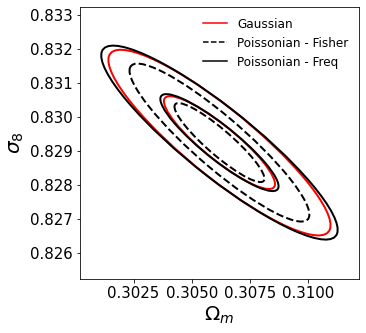

In [39]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
x=0.006
y=0.004
utils._make_ellipse(True_value, covFisher_Gauss, ax, level=0.95, color='r', label = 'Gaussian', ls = '-')
utils._make_ellipse(True_value, covFisher_Poiss, ax, level=0.95, color='k', label = 'Poissonian - Fisher', ls = '--')
utils._make_ellipse(True_value, cov_freq_GP, ax, level=0.95, color='k', label = 'Poissonian - Freq', ls = '-')
#utils._make_ellipse(True_value, cov_freq_GG, ax, level=0.95, color='b', label = 'Frequentist Gauss', ls = '-')
ax.set_xlim(True_value[0]-x, True_value[0]+x)
ax.set_ylim(True_value[1]-y, True_value[1]+y)
ax.set_ylabel(r'$\sigma_8$', fontsize=20)
ax.set_xlabel(r'$\Omega_m$', fontsize=20)
ax.tick_params(axis='both', which = 'major', labelsize= 15)
plt.legend(fontsize=12, frameon=False)
#plt.savefig('err_Freq_vs_Bayes.pdf', bbox_inches='tight', dpi=300)